# Training Notebook 

This notebook covers only training part with model definition, if all data visualization, inference etc. and original notebooks with all explanations are required that can be found inside `"Original Training Notebooks"` Folder.

#### Setting up COCOAPI

Clone the original COCOAPI repo into working directory, and run install command. 

In [1]:
!git clone https://github.com/cocodataset/cocoapi

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 30.47 MiB/s, done.
Resolving deltas: 100% (575/575), done.


In [ ]:
%%shell
cd cocoapi/PythonAPI
python setup.py build_ext install

In [ ]:
#========================================================
# Download dataset and extract it to current directory
#========================================================

import time

file_download_start = time.time()
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip -q train2014.zip
!rm train2014.zip

print("Time to download and unzip dataset (mins): "+str((time.time()-file_download_start)/60))

In [4]:
!wget http://images.cocodataset.org/annotations/image_info_test2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip

!unzip -q image_info_test2014.zip
!unzip -q annotations_trainval2014.zip

!rm image_info_test2014.zip
!rm annotations_trainval2014.zip

--2020-12-28 10:34:27--  http://images.cocodataset.org/annotations/image_info_test2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.226.176
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.226.176|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 763464 (746K) [application/zip]
Saving to: ‘image_info_test2014.zip’

image_info_test2014 100%[===================>] 745.57K  2.29MB/s    in 0.3s    

2020-12-28 10:34:27 (2.29 MB/s) - ‘image_info_test2014.zip’ saved [763464/763464]

--2020-12-28 10:34:27--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.12.4
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.12.4|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M 

In [ ]:
#==========================================================================
#  Create "Data" folder and move training and annotations folders into it
#==========================================================================
%%shell
mkdir Data
mv train2014 Data/
mv annotations Data/

In [10]:
# ==================================================
# All Imports
# ==================================================
import os
import sys
import time
import requests
from collections import Counter

import numpy as np
import math
import skimage.io as io
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('punkt')

import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms

from data_loader import get_loader
import model
from model import EncoderCNN, DecoderRNN, save_checkpoint, load_checkpoint


sys.path.append('cocoapi/PythonAPI')
from pycocotools.coco import COCO


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MANU\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def plot_logs(fileLocation):
    """
    Takes file location for log txt file and plots loss curve per 500 intervals
    """
    loss = []
    perp = []
    step = []
    with open(fileLocation, "r") as f:
        myLogs = f.readlines()
        interval = 500
        count = 1
        for line in myLogs:
            if(count%interval == 0):
                loss.append(float(line.split(",")[2].strip().split(" ")[1]))
                perp.append(float(line.split(",")[3].strip().split(" ")[1]))
                step.append(count)
                
            count += 1
    
    
    fig, axs = plt.subplots(2, figsize=(15,10))
    fig.suptitle('Training Logs')
    axs[0].set_title("Loss")
    axs[1].set_title("Perplexity")
    
    axs[0].plot(step, loss, color="g",marker=".")
    axs[1].plot(step, perp, color="m",marker=".")
    plt.show()
    
    

In [4]:
def trainNetwork(encoder,decoder,optimizer,criterion,total_step, device ,start_epoch=1,end_epoch=2,log_file="training_log.txt"):
    """
    Returns the sum of two decimal numbers in binary digits.

            Parameters:
                    encoder : Encoder CNN model
                    decoder : Decoder LSTM RNN model
                    optimizer: Optimizer set to work on both model's parameters
                    criterion: Loss function
                    total_step: Total Steps per epoch
                    device: Training device, if GPU is available then "cuda" is "cpu"
                    start_epoch: (Default = 1) Epoch start count (since we can start from epoch X on a already trained model, this is required for logging)
                    end_epoch: (Default = 2) Epoch upto which we want to train+1, for example if we want to train for 3 epochs
                                (start_epoch = 1, end_epoch = 3+1 = 4 ), or if model will resume after epoch 2 then (start_epoch = 3, end_epoch = 6)
                                
                    log_file: Log file location where logs are needed to be saved
                
            Returns:
                    trained encoder and decoder model
    """
    
    
    print("\nTraining Network on: "+str(device))
    
    start_time = time.time()
    f = open(log_file,'w')
    
    for epoch in range(start_epoch,end_epoch):
        for step in range(1,total_step+1):
            
            indices = train_loader.dataset.get_train_indices()
            new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
            train_loader.batch_sampler.sampler = new_sampler
            
            # Load data and move to device (which is either CPU or GPU)
            images,captions = next(iter(train_loader))
            images = images.to(device)
            captions = captions.to(device)
            
            # Clear any gradients which was calculated previously
            encoder.zero_grad()
            decoder.zero_grad()
            
            # Forward Pass to both networks
            features = encoder(images)
            outputs = decoder(features,captions)
            
            # Calculate loss and backward pass to update weights
            loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
            loss.backward()
            optimizer.step()

            # Get training statistics.
            stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f, Time (mins): %.3f' % (epoch, end_epoch-1, step, total_step, loss.item(), np.exp(loss.item()), (time.time()-start_time)/60)
            
            # Print training statistics (on same line).
            print('\r' + stats, end="")
            sys.stdout.flush()

            # Print training statistics to file.
            f.write(stats + '\n')
            f.flush()

            # Print training statistics (on different line).
            if step % print_every == 0:
                print('\r' + stats)
        
        if epoch % save_every == 0:
            # Save model checkpoints to given path
            save_checkpoint(encoder,"drive/MyDrive/saved_models/encoderEpoch_"+str(epoch)+".pth")
            save_checkpoint(decoder,"drive/MyDrive/saved_models/decoderEpoch_"+str(epoch)+".pth")
    
    f.close()
    
    print("============================================================================")
    print("Total Training Time (hours): "+str((time.time()-start_time)/3600))
    print("============================================================================")
    return encoder, decoder

In [16]:
## TODO #1: Select appropriate values for the Python variables below.
batch_size = 32          # batch size
vocab_threshold = 4        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 2             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity
num_layers = 2

# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
train_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(train_loader.dataset.vocab)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(train_loader.dataset.caption_lengths) / train_loader.batch_sampler.batch_size)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.69s)
creating index...


  0%|          | 1647/414113 [00:00<00:51, 7950.28it/s]

index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:45<00:00, 9024.37it/s]


In [25]:
# Initialize the encoder and decoder. 
from model import EncoderCNN, DecoderRNN
%load_ext autoreload
%autoreload 2

encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers = num_layers)

#===================================================================================
#   If model is being trained from scratch and not from an existing checkpoint file 
#   then comment below two lines
#===================================================================================
encoder.load_state_dict(torch.load("model_checkpoints/encoderEpoch_1.pth"))
decoder.load_state_dict(torch.load("model_checkpoints/decoderEpoch_1.pth"))


# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters())  + list(encoder.embed.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001)
decoder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DecoderRNN(
  (embed): Embedding(9947, 512)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=512, out_features=9947, bias=True)
)

In [ ]:
encoder, decoder = trainNetwork(encoder,decoder,optimizer,criterion,total_step,
                                device = device,
                                start_epoch=1,
                                end_epoch=2,
                                log_file="training_log.txt")


Training Network on: cuda
Epoch [1/1], Step [100/12942], Loss: 4.8235, Perplexity: 124.4038, Time (mins): 1.188
Epoch [1/1], Step [200/12942], Loss: 3.9776, Perplexity: 53.3887, Time (mins): 2.372
Epoch [1/1], Step [300/12942], Loss: 3.3964, Perplexity: 29.8576, Time (mins): 3.554
Epoch [1/1], Step [400/12942], Loss: 3.6008, Perplexity: 36.6267, Time (mins): 4.738
Epoch [1/1], Step [500/12942], Loss: 3.4057, Perplexity: 30.1362, Time (mins): 5.914
Epoch [1/1], Step [600/12942], Loss: 3.1861, Perplexity: 24.1939, Time (mins): 7.066
Epoch [1/1], Step [700/12942], Loss: 3.5165, Perplexity: 33.6653, Time (mins): 8.191
Epoch [1/1], Step [800/12942], Loss: 3.2494, Perplexity: 25.7744, Time (mins): 9.312
Epoch [1/1], Step [900/12942], Loss: 3.2417, Perplexity: 25.5759, Time (mins): 10.425
Epoch [1/1], Step [1000/12942], Loss: 3.2362, Perplexity: 25.4374, Time (mins): 11.525
Epoch [1/1], Step [1100/12942], Loss: 3.3541, Perplexity: 28.6198, Time (mins): 12.615
Epoch [1/1], Step [1200/12942], 

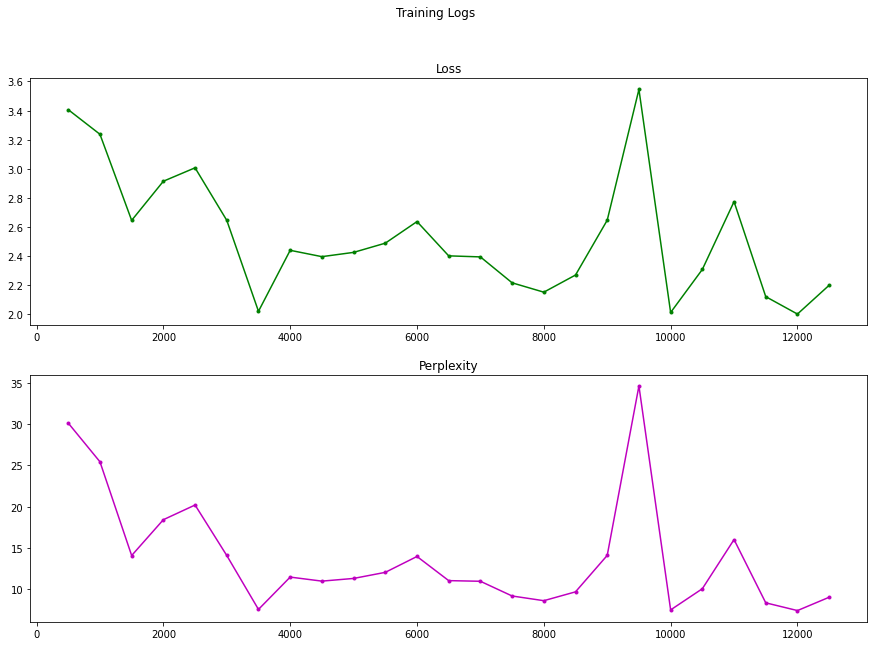

In [ ]:
plot_logs("training_log.txt")

In [26]:
encoder, decoder = trainNetwork(encoder,decoder,optimizer,criterion,total_step,
                                device = device,
                                start_epoch=2,
                                end_epoch=3,
                                log_file="training_log.txt")


Training Network on: cuda
Epoch [2/2], Step [100/12942], Loss: 2.2830, Perplexity: 9.8057, Time (mins): 1.233
Epoch [2/2], Step [200/12942], Loss: 2.2016, Perplexity: 9.0395, Time (mins): 2.460
Epoch [2/2], Step [300/12942], Loss: 2.4914, Perplexity: 12.0786, Time (mins): 3.681
Epoch [2/2], Step [400/12942], Loss: 2.4694, Perplexity: 11.8151, Time (mins): 4.891
Epoch [2/2], Step [500/12942], Loss: 2.1339, Perplexity: 8.4474, Time (mins): 6.092
Epoch [2/2], Step [600/12942], Loss: 2.6743, Perplexity: 14.5017, Time (mins): 7.292
Epoch [2/2], Step [700/12942], Loss: 2.0915, Perplexity: 8.0967, Time (mins): 8.495
Epoch [2/2], Step [800/12942], Loss: 2.2154, Perplexity: 9.1650, Time (mins): 9.699
Epoch [2/2], Step [900/12942], Loss: 2.1225, Perplexity: 8.3516, Time (mins): 10.900
Epoch [2/2], Step [1000/12942], Loss: 2.1133, Perplexity: 8.2758, Time (mins): 12.094
Epoch [2/2], Step [1100/12942], Loss: 2.3938, Perplexity: 10.9552, Time (mins): 13.296
Epoch [2/2], Step [1200/12942], Loss: 3.

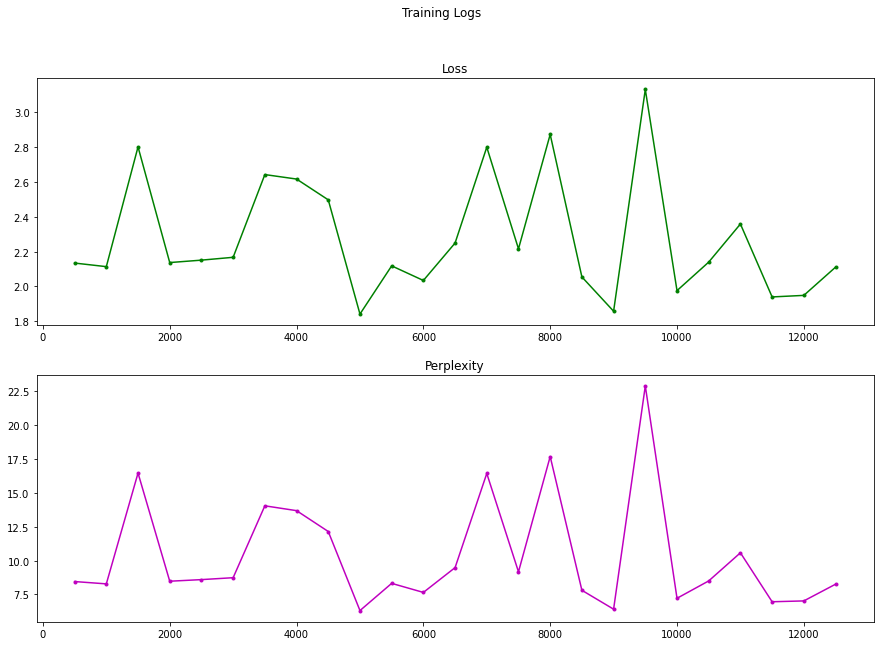

In [27]:
plot_logs("training_log.txt")

## Inference on Trained Model

1. Download and unzip test dataset
2. Generate test dataloader
3. Load trained model from checkpoint (or existing model can be used if not already cleared from memory)
3. Iterate over examples to see result
4. Do prediction on input images from local filesystem

In [ ]:
#============================================
# Download and Extract Test Files
#============================================
!wget http://images.cocodataset.org/zips/test2014.zip
!unzip -q test2014.zip
!rm test2014.zip

In [2]:
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
test_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


In [3]:
encoder_file = "model_checkpoints/encoderEpoch_2.pth" 
decoder_file = "model_checkpoints/decoderEpoch_2.pth"

embed_size = 512
hidden_size = 512
vocab_size = len(test_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers=2)

# Load the trained weights.
encoder.load_state_dict(torch.load(encoder_file))
decoder.load_state_dict(torch.load(decoder_file))

# Put model to evaluation mode
encoder.eval()
decoder.eval()

# Move models to GPU if CUDA is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embed): Embedding(9947, 512)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=512, out_features=9947, bias=True)
)

In [4]:
def clean_sentence(output):
    cleaned = []
    for index in output:
        cleaned.append(test_loader.dataset.vocab.idx2word[index])
    cleaned = cleaned[1:-1]
    sentence = ' '.join(cleaned) 
    return sentence

def get_prediction():
    orig_image, image = next(iter(test_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)
    
    
def predict_input_images(image_path):
    image = Image.open(image_path)
    original_image = np.copy(image)
    image = torch.unsqueeze(transform_test(image), 0).to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    plt.imshow(original_image)
    plt.title('Input Image: '+image_path)
    plt.show()
    print("="*len(sentence))
    print(sentence)
    print("="*len(sentence))


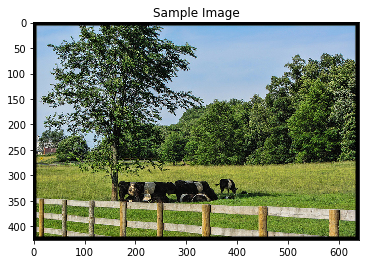

a group of cows standing in a field .


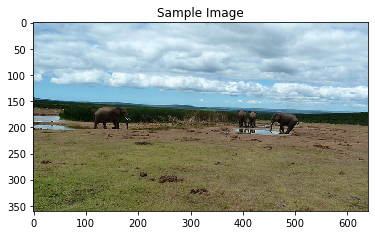

a group of elephants standing in a field .


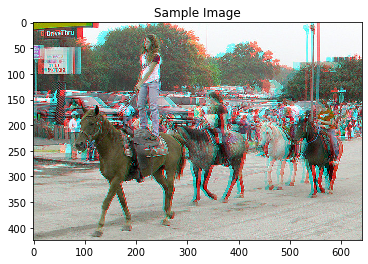

a group of people riding on the back of a horse .


(None, None, None)

In [25]:
get_prediction(),get_prediction(),get_prediction()

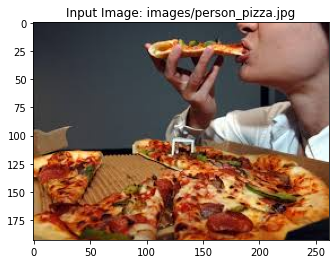

a man is eating a slice of pizza from a plate .


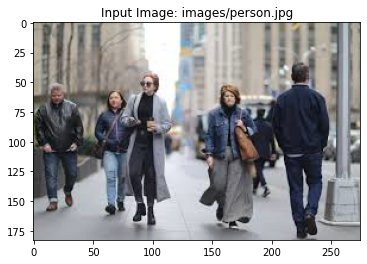

a group of people standing on a sidewalk .


(None, None)

In [11]:
predict_input_images("images/person_pizza.jpg"),predict_input_images("images/person.jpg")

In [17]:
print(test_loader.dataset.vocab.annotations_file)

Data/annotations/image_info_test2014.json


In [21]:
dir(test_loader.dataset.vocab)
print(test_loader.dataset.vocab.)
print(test_loader.dataset.vocab.)
print(test_loader.dataset.vocab.)
print(test_loader.dataset.vocab.)
print(test_loader.dataset.vocab.)
print(test_loader.dataset.vocab.)
print(test_loader.dataset.vocab.)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_captions',
 'add_word',
 'annotations_file',
 'build_vocab',
 'end_word',
 'get_vocab',
 'idx2word',
 'init_vocab',
 'start_word',
 'unk_word',
 'vocab_file',
 'vocab_from_file',
 'vocab_threshold',
 'word2idx']

### Technical Specification of System Used

GPU and CPU Information at Google Colab when model was trained

In [9]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9f857b56-02c9-6c5b-1364-c5dd6e5919ea)


In [10]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

Mon Dec 28 10:34:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [12]:
#no.of sockets i.e available slots for physical processors
!lscpu | grep 'Socket(s):'

Socket(s):           1


In [13]:
#no.of cores each processor is having 
!lscpu | grep 'Core(s) per socket:'

Core(s) per socket:  1


In [14]:
#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'

Thread(s) per core:  2
